# Wind Downscaling

## Prerequisites

* Conda environment
* Get a Copernicus API key from: https://cds.climate.copernicus.eu/api-how-to
  * create a file at \$HOME/.cdsapirc with the required UID and key
* Create a .env file in the same folder as this notebook, and add the COSMO_USERNAME and COSMO_PASSWORD to connect to the UNI-BE server

## Install the required packages

In [1]:
from datetime import date
from pathlib import Path
import os

In [2]:
if Path('./setup.py').exists():
    !pip install -e .
else:
    !pip install -U git+https://github.com/OpheliaMiralles/WindDownscaling_EPFL_UNIBE.git

Obtaining file:///Users/Boubou/Documents/GitHub/WindDownscaling_EPFL_UNIBE
  Attempting uninstall: downscaling
    Found existing installation: downscaling 1.0
    Uninstalling downscaling-1.0:
      Successfully uninstalled downscaling-1.0
  Running setup.py develop for downscaling


In [5]:
from dotenv import load_dotenv
load_dotenv()
import numpy as np
import tensorflow as tf
import tensorflow.keras.callbacks as cb
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

Num GPUs Available: 0


## Set configuration

In [6]:
DATA_ROOT = Path('./data')
PROCESSED_DATA_FOLDER = DATA_ROOT / 'img_prediction_files'

DATA_ROOT.mkdir(parents=True, exist_ok=True)
PROCESSED_DATA_FOLDER.mkdir(exist_ok=True)

In [7]:
TOPO_PREDICTORS = ('tpi_500', 'ridge_index_norm', 'ridge_index_dir',
                   'we_derivative', 'sn_derivative',
                   'slope', 'aspect')
HOMEMADE_PREDICTORS = ('e_plus', 'e_minus')
ALL_INPUTS = ['U_10M', 'V_10M']+ list(HOMEMADE_PREDICTORS) + list(TOPO_PREDICTORS)
ALL_OUTPUTS = ['U_10M', 'V_10M']

In [8]:
# Start and end date for the data - should be in the 2016-2020 range
START_DATE = date(2017,1,1)
END_DATE = date(2017,31,12)
NUM_DAYS = (END_DATE-START_DATE).days + 1
# Number of consecutive images to form a sequence
SEQUENCE_LENGTH = 3
# Size of the high resolution image to be produced
IMG_SIZE = 128
# Number of noise channels to add to the image
NOISE_CHANNELS = 500
# Number of sequences per batch
BATCH_SIZE = 8
# Number of workers to run to process the data to create the batches
BATCH_WORKERS = 8
# Latent dimension for the autoencoder
USE_AUTOENCODER = True
AUTOENCODER_OUTPUT_FEATURES = 8

In [ ]:
from data.data_generator import BatchGenerator, NaiveDecoder

batch_gen = BatchGenerator(path_to_data=PROCESSED_DATA_FOLDER,
                           decoder=NaiveDecoder(normalize=True),
                           input_pattern='x_cosmo_{}',
                           sequence_length=SEQUENCE_LENGTH,
                           patch_length_pixel=IMG_SIZE, batch_size=BATCH_SIZE,
                           input_variables=ALL_INPUTS,
                           output_variables= ALL_OUTPUTS,
                           start_date=START_DATE, end_date=END_DATE,
                           num_workers=BATCH_WORKERS)

inputs = []
outputs = []
with batch_gen as batch:
    for b in range(NUM_DAYS):
        print(f'Creating batch {b+1}/{NUM_DAYS}')
        x, y = next(batch)
        inputs.append(x)
        outputs.append(y)
inputs = np.concatenate(inputs, axis=0)
outputs = np.concatenate(outputs, axis=0)
print(f"Inputs: {inputs.shape}")
print(f"Outputs: {outputs.shape}")

In [14]:
INPUT_CHANNELS = len(ALL_INPUTS)
OUT_CHANNELS = len(ALL_OUTPUTS)

In [15]:
from gan import train, metrics
from gan.models import make_generator, make_discriminator
generator = make_generator(image_size=IMG_SIZE, in_channels=INPUT_CHANNELS,
                           noise_channels=NOISE_CHANNELS, out_channels=OUT_CHANNELS,
                           n_timesteps=SEQUENCE_LENGTH)
print(f"Generator: {generator.count_params():,} weights")

discriminator = make_discriminator(low_res_size=IMG_SIZE, high_res_size=IMG_SIZE, low_res_channels=INPUT_CHANNELS,
                                   high_res_channels=OUT_CHANNELS, n_timesteps=SEQUENCE_LENGTH)
print(f"Discriminator: {discriminator.count_params():,} weights")

Generator: 6,998,482 weights
Discriminator: 9,103,241 weights


In [16]:
from gan.ganbase import  GAN
from data.data_generator import FlexibleNoiseGenerator

noise_shape = (BATCH_SIZE, SEQUENCE_LENGTH, IMG_SIZE, IMG_SIZE, NOISE_CHANNELS)
gan = GAN(generator, discriminator, noise_generator=FlexibleNoiseGenerator(noise_shape, std=1))

print(f"Total: {gan.generator.count_params() + gan.discriminator.count_params():,} weights")

Total: 16,101,723 weights


In [17]:
gan.compile(generator_optimizer=train.generator_optimizer(),
            generator_metrics= [tf.keras.metrics.RootMeanSquaredError(), metrics.LogSpectralDistance(),
                                metrics.WeightedRMSEForExtremes(), metrics.WindSpeedWeightedRMSE()],
            discriminator_optimizer=train.discriminator_optimizer(),
                discriminator_loss=train.discriminator_loss,
           metrics = [metrics.discriminator_score_fake(), metrics.discriminator_score_real()])

In [18]:
checkpoint_path_weights = Path('./checkpoints/gan/weights-{epoch:02d}.ckpt')
checkpoint_path_weights.parent.mkdir(exist_ok=True, parents=True)
log_path = Path('./logs/gan')
if log_path.exists():
    log_path_str = str(log_path)
    !rm -rf {log_path_str}

In [19]:
%load_ext tensorboard
%tensorboard --logdir=logs/gan

In [20]:
import matplotlib.pyplot as plt
def show(images, dims=1, legends=None):
    fig, axes = plt.subplots(ncols= len(images), figsize=(10, 10))
    for ax, im in zip(axes, images):
        for i in range(dims):
            label = legends[i] if legends is not None else ''
            ax.imshow(im[0, :, :, i], cmap='jet')
            ax.set_title(label)
            ax.axis('off')
    plt.show()
    return fig

In [21]:
class ShowCallback(tf.keras.callbacks.Callback):
    def __init__(self, dims):
        self.dims = dims
        
    def on_epoch_begin(self, epoch, logs):
        noise = FlexibleNoiseGenerator(noise_shape)
        show(self.model.generator([inputs[:self.dims], noise(self.dims)]))

In [22]:
callbacks = [
    cb.TensorBoard(log_path, write_images=True, update_freq='batch', profile_batch=(2, 4)),
    cb.ProgbarLogger('steps'),
    cb.TerminateOnNaN(),
    ShowCallback(10),
    cb.ModelCheckpoint(str(checkpoint_path_weights), monitor='g_ws_weighted_rmse', mode='min',
                       save_best_only=False, period=3, save_weights_only=True),
]

Epoch 1/20


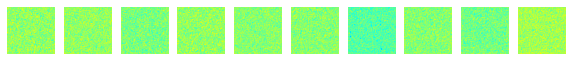

24/24 [==============================] - 449s 18s/step - d_loss: 2.9355e-08 - g_loss: -1.4305e-08 - d_fake: -1.7111e-09 - d_real: 2.5570e-08 - g_root_mean_squared_error: 3.3160 - g_lsd: 12.9207 - g_extreme_rmse: 2.5381 - g_ws_weighted_rmse: 6.9005 - val_loss: 0.0104 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 2/20


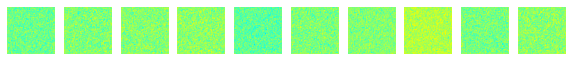

24/24 [==============================] - 418s 17s/step - d_loss: 5.7220e-08 - g_loss: -4.6790e-08 - d_fake: -2.9381e-08 - d_real: 1.9154e-09 - g_root_mean_squared_error: 3.3635 - g_lsd: 12.8625 - g_extreme_rmse: 2.5526 - g_ws_weighted_rmse: 7.0078 - val_loss: 0.0161 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 3/20


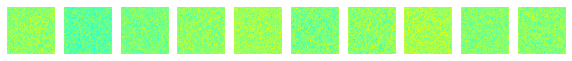

24/24 [==============================] - 418s 17s/step - d_loss: 1.8924e-08 - g_loss: -4.0084e-08 - d_fake: -4.6155e-08 - d_real: -1.7411e-08 - g_root_mean_squared_error: 3.3877 - g_lsd: 12.8075 - g_extreme_rmse: 2.5784 - g_ws_weighted_rmse: 7.1104 - val_loss: 0.0320 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 4/20


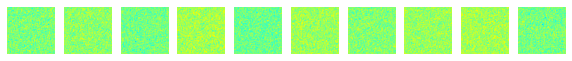

24/24 [==============================] - 415s 17s/step - d_loss: 1.3709e-08 - g_loss: -2.3842e-09 - d_fake: -2.9805e-08 - d_real: -3.0666e-08 - g_root_mean_squared_error: 3.3896 - g_lsd: 12.8093 - g_extreme_rmse: 2.5787 - g_ws_weighted_rmse: 7.1183 - val_loss: 0.0387 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 5/20


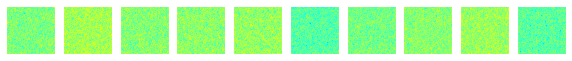

24/24 [==============================] - 414s 17s/step - d_loss: -2.3246e-08 - g_loss: 9.8348e-09 - d_fake: 2.8611e-08 - d_real: -1.3956e-08 - g_root_mean_squared_error: 3.3878 - g_lsd: 12.8240 - g_extreme_rmse: 2.5713 - g_ws_weighted_rmse: 7.1015 - val_loss: 0.0896 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 6/20


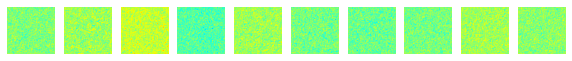

24/24 [==============================] - 424s 18s/step - d_loss: -1.4901e-08 - g_loss: 5.7369e-09 - d_fake: -2.0533e-08 - d_real: -1.3379e-08 - g_root_mean_squared_error: 3.3837 - g_lsd: 12.8259 - g_extreme_rmse: 2.5705 - g_ws_weighted_rmse: 7.0884 - val_loss: 0.0489 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 7/20


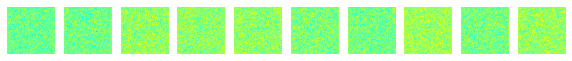

 3/24 [==>...........................] - ETA: 6:06 - d_loss: -1.9868e-08 - g_loss: -2.9802e-08 - d_fake: 0.0000e+00 - d_real: -2.1524e-08 - g_root_mean_squared_error: 3.3791 - g_lsd: 12.8256 - g_extreme_rmse: 2.5689 - g_ws_weighted_rmse: 7.0707

In [ ]:
gan.fit(inputs, outputs, callbacks=callbacks, epochs=20, batch_size=BATCH_SIZE, validation_split=0.25)

In [ ]:
for epoch in [6,8,12,35,40,50]:
    gan.load_weights(f'checkpoints/gan/weights-{epoch:02d}.ckpt')
    noise = FlexibleNoiseGenerator(noise_shape)()
    if not os.path.exists(f'plots/gan_pred/{epoch}'):
        os.mkdir(f'plots/gan_pred/{epoch}')
    for i in range(0, BATCH_SIZE*6, BATCH_SIZE):
        results = gan.generator.predict([inputs[i:i+BATCH_SIZE], noise])
        j=0
        for inp, out, res in zip(inputs[i:i+BATCH_SIZE], outputs[i:i+BATCH_SIZE], results):
            fig = show([inp, out, res])
            fig.savefig(f'plots/gan_pred/{epoch}/inp_{i}_batch_{j}.png')
            j+=1